# Test problem 2: Flow past a cylinder (DFG 2D-3 benchmark)

Author: Jørgen S. Dokken

In this section, we will turn our attention to a slightly more challenging problem: flow past a cylinder. The geometry and parameters are taken from the [DFG 2D-3 benchmark](https://www.featflow.de/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark3_re100.html) in FeatFlow.

To be able to solve this problem efficiently and ensure numerical stability, we will substitute our first order backward difference scheme with a Crank-Nicholson discretization in time, and a semi-implicit Adams-Bashforth approximation of the non-linear term.

```{admonition} Computationally demanding demo
This demo is computationally demanding, with a run-time up to 15 minutes, as it is using parameters from the DFG 2D-3 benchmark, which consists of 12800 time steps. It is adviced to download this demo and  not run it in a browser. This runtime of the demo can be increased by using 2 or 3 mpi processes.
```

The computational geometry we would like to use is
![Fluid channel with a circular obstacle](turek.png)

The kinematic velocity is given by $\nu=0.001=\frac{\mu}{\rho}$ and the inflow velocity profile is specified as

$$
    u(x,y,t) = \left( \frac{4Uy(0.41-y)}{0.41^2}, 0 \right)
$$

$$
    U=U(t) = 1.5\sin(\pi t/8)
$$

which has a maximum magnitude of $1.5$ at $y=0.41/2$. We do not use any scaling for this problem since all exact parameters are known.

## Mesh generation

As in the [Deflection of a membrane](./../chapter1/membrane_code.ipynb) we use GMSH to generate the mesh. We fist create the rectangle and obstacle.


In [1]:
import gmsh
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm.autonotebook

from mpi4py import MPI
from petsc4py import PETSc

from basix.ufl import element

from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import (Constant, Function, functionspace,
                         assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc)
from dolfinx.fem.petsc import (apply_lifting, assemble_matrix, assemble_vector,
                               create_vector, create_matrix, set_bc)
from dolfinx.graph import adjacencylist
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from dolfinx.io import (VTXWriter, distribute_entity_data, gmshio)
from dolfinx.mesh import create_mesh, meshtags_from_entities
from ufl import (FacetNormal, Identity, Measure, TestFunction, TrialFunction,
                 as_vector, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym, system)
import adios4dolfinx
from pathlib import Path

gmsh.initialize()

L = 2.2
H = 0.41
c_x = c_y = 0.2
r = 0.05
gdim = 2
mesh_comm = MPI.COMM_WORLD
model_rank = 0
if mesh_comm.rank == model_rank:
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

/var/folders/m2/27593vrn285gs5xg8w4fpdr80000gn/T/ipykernel_22747/2895302684.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook


The next step is to subtract the obstacle from the channel, such that we do not mesh the interior of the circle.


In [2]:
if mesh_comm.rank == model_rank:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()

To get GMSH to mesh the fluid, we add a physical volume marker


In [3]:
fluid_marker = 1
if mesh_comm.rank == model_rank:
    volumes = gmsh.model.getEntities(dim=gdim)
    assert (len(volumes) == 1)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

To tag the different surfaces of the mesh, we tag the inflow (left hand side) with marker 2, the outflow (right hand side) with marker 3 and the fluid walls with 4 and obstacle with 5. We will do this by computing the center of mass for each geometrical entity.


In [4]:
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
if mesh_comm.rank == model_rank:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
        if np.allclose(center_of_mass, [0, H / 2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H / 2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(center_of_mass, [L / 2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In our previous meshes, we have used uniform mesh sizes. In this example, we will have variable mesh sizes to resolve the flow solution in the area of interest; close to the circular obstacle. To do this, we use GMSH Fields.


In [5]:
# Create distance field from obstacle.
# Add threshold of mesh sizes based on the distance field
# LcMax -                  /--------
#                      /
# LcMin -o---------/
#        |         |       |
#       Point    DistMin DistMax
res_min = r / 3
if mesh_comm.rank == model_rank:
    distance_field = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)
    threshold_field = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(threshold_field, "IField", distance_field)
    gmsh.model.mesh.field.setNumber(threshold_field, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(threshold_field, "LcMax", 0.25 * H)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMin", r)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMax", 2 * H)
    min_field = gmsh.model.mesh.field.add("Min")
    gmsh.model.mesh.field.setNumbers(min_field, "FieldsList", [threshold_field])
    gmsh.model.mesh.field.setAsBackgroundMesh(min_field)

## Generating the mesh

We are now ready to generate the mesh. However, we have to decide if our mesh should consist of triangles or quadrilaterals. In this demo, to match the DFG 2D-3 benchmark, we use second order quadrilateral elements.


In [6]:
if mesh_comm.rank == model_rank:
    gmsh.option.setNumber("Mesh.Algorithm", 8)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)
    gmsh.option.setNumber("Mesh.RecombineAll", 1)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.setOrder(2)
    gmsh.model.mesh.optimize("Netgen")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Ellipse)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.00393442s, CPU 0.003917s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay for Quads)
Info    : Simple recombination completed (Wall 0.00138271s, CPU 0.001321s): 103 quads, 16 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.82361, min Q = 0.425555
Info    : Simple recombination completed (Wall 0.00196063s, CPU 0.001941s): 460 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.865979, min Q = 0.499255
Info    : Done meshing 2D (Wall 0.00563596s, CPU 0.005534s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 5 order 2
Info    : [ 20%] Meshing curve 6 order 2
Info    : [ 40%] Meshing curve 7 order 2
Info    : [ 60%] Mesh

## Loading mesh and boundary markers

As we have generated the mesh, we now need to load the mesh and corresponding facet markers into DOLFINx.
To load the mesh, we follow the same structure as in [Deflection of a membrane](./../chapter1/membrane_code.ipynb), with the difference being that we will load in facet markers as well. To learn more about the specifics of the function below, see [A GMSH tutorial for DOLFINx](https://jsdokken.com/src/tutorial_gmsh.html).


In [7]:
mesh, _, ft = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
ft.name = "Facet markers"

Storing the mesh

In [8]:
cp_filename = Path("./function_checkpoint.bp")
adios4dolfinx.write_mesh(cp_filename, mesh)

## Physical and discretization parameters

Following the DGF-2 benchmark, we define our problem specific parameters


t = 0
T = 8                       # Final time
dt = 1 / 1600                 # Time step size
num_steps = int(T / dt)
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(0.001))  # Dynamic viscosity
rho = Constant(mesh, PETSc.ScalarType(1))     # Density

```{admonition} Reduced end-time of problem
In the current demo, we have reduced the run time to one second to make it easier to illustrate the concepts of the benchmark. By increasing the end-time `T` to 8, the runtime in a notebook is approximately 25 minutes. If you convert the notebook to a python file and use `mpirun`, you can reduce the runtime of the problem.
```

## Boundary conditions

As we have created the mesh and relevant mesh tags, we can now specify the function spaces `V` and `Q` along with the boundary conditions. As the `ft` contains markers for facets, we use this class to find the facets for the inlet and walls.


In [10]:
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

fdim = mesh.topology.dim - 1

# Define boundary conditions


class InletVelocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (0.41 - x[1]) / (0.41**2)
        return values


# Inlet
u_inlet = Function(V)
inlet_velocity = InletVelocity(t)
u_inlet.interpolate(inlet_velocity)
bcu_inflow = dirichletbc(u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker)))
# Walls
u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bcu_walls = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V)
# Obstacle
bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V)
bcu = [bcu_inflow, bcu_obstacle, bcu_walls]
# Outlet
bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q)
bcp = [bcp_outlet]

## Variational form

As opposed to [Pouseille flow](./ns_code1.ipynb), we will use a Crank-Nicolson discretization, and an semi-implicit Adams-Bashforth approximation.
The first step can be written as

$$
\rho\left(\frac{u^*- u^n}{\delta t} + \left(\frac{3}{2}u^{n} - \frac{1}{2} u^{n-1}\right)\cdot \frac{1}{2}\nabla (u^*+u^n) \right) - \frac{1}{2}\mu \Delta( u^*+ u^n )+ \nabla p^{n-1/2} = f^{n+\frac{1}{2}} \qquad \text{ in } \Omega
$$

$$
u^{*}=g(\cdot, t^{n+1}) \qquad \text{ on } \partial \Omega_{D}
$$

$$
\frac{1}{2}\nu \nabla (u^*+u^n) \cdot n = p^{n-\frac{1}{2}} \qquad \text{ on } \partial \Omega_{N}
$$

where we have used the two previous time steps in the temporal derivative for the velocity, and compute the pressure staggered in time, at the time between the previous and current solution. The second step becomes

$$
\nabla^2 \phi = \frac{\rho}{\delta t} \nabla \cdot u^* \qquad\text{in } \Omega,
$$

$$
\nabla \phi \cdot n = 0 \qquad \text{on } \partial \Omega_D,
$$

$$
\phi = 0 \qquad\text{on } \partial\Omega_N
$$

where $p^{n+\frac{1}{2}}=p^{n-\frac{1}{2}} + \phi$.
Finally, the third step is

$$
\rho (u^{n+1}-u^{*}) = -\delta t \nabla\phi.
$$

We start by defining all the variables used in the variational formulations.


In [11]:
u = TrialFunction(V)
v = TestFunction(V)
u_ = Function(V)
u_.name = "u"
u_s = Function(V)
u_n = Function(V)
u_n1 = Function(V)
p = TrialFunction(Q)
q = TestFunction(Q)
p_ = Function(Q)
p_.name = "p"
phi = Function(Q)

Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts.


In [12]:
f = Constant(mesh, PETSc.ScalarType((0, 0)))
F1 = rho / k * dot(u - u_n, v) * dx
F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
F1 += dot(f, v) * dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))
A1 = create_matrix(a1)
b1 = create_vector(L1)

Next we define the second step


In [13]:
a2 = form(dot(grad(p), grad(q)) * dx)
L2 = form(-rho / k * dot(div(u_s), q) * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

We finally create the last step


In [14]:
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

As in the previous tutorials, we use PETSc as a linear algebra backend.


In [15]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.JACOBI)

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.MINRES)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

## Verification of the implementation compute known physical quantities

As a further verification of our implementation, we compute the drag and lift coefficients over the obstacle, defined as

$$
    C_{\text{D}}(u,p,t,\partial\Omega_S) = \frac{2}{\rho L U_{mean}^2}\int_{\partial\Omega_S}\rho \nu n \cdot \nabla u_{t_S}(t)n_y -p(t)n_x~\mathrm{d} s,
$$

$$
    C_{\text{L}}(u,p,t,\partial\Omega_S) = -\frac{2}{\rho L U_{mean}^2}\int_{\partial\Omega_S}\rho \nu n \cdot \nabla u_{t_S}(t)n_x + p(t)n_y~\mathrm{d} s,
$$

where $u_{t_S}$ is the tangential velocity component at the interface of the obstacle $\partial\Omega_S$, defined as $u_{t_S}=u\cdot (n_y,-n_x)$, $U_{mean}=1$ the average inflow velocity, and $L$ the length of the channel. We use `UFL` to create the relevant integrals, and assemble them at each time step.


In [16]:
n = -FacetNormal(mesh)  # Normal pointing out of obstacle
dObs = Measure("ds", domain=mesh, subdomain_data=ft, subdomain_id=obstacle_marker)
u_t = inner(as_vector((n[1], -n[0])), u_)
drag = form(2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[1] - p_ * n[0]) * dObs)
lift = form(-2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[0] + p_ * n[1]) * dObs)
if mesh.comm.rank == 0:
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)

We will also evaluate the pressure at two points, one in front of the obstacle, $(0.15, 0.2)$, and one behind the obstacle, $(0.25, 0.2)$. To do this, we have to find which cell contains each of the points, so that we can create a linear combination of the local basis functions and coefficients.


In [17]:
tree = bb_tree(mesh, mesh.geometry.dim)
points = np.array([[0.15, 0.2, 0], [0.25, 0.2, 0]])
cell_candidates = compute_collisions_points(tree, points)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, points)
front_cells = colliding_cells.links(0)
back_cells = colliding_cells.links(1)
if mesh.comm.rank == 0:
    p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)

## Solving the time-dependent problem

```{admonition} Stability of the Navier-Stokes equation
Note that the current splitting scheme has to fullfil the a [Courant–Friedrichs–Lewy condition](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition). This limits the spatial discretization with respect to the inlet velocity and temporal discretization.
Other temporal discretization schemes such as the second order backward difference discretization or Crank-Nicholson discretization with Adams-Bashforth linearization are better behaved than our simple backward difference scheme.
```

As in the previous example, we create output files for the velocity and pressure and solve the time-dependent problem. As we are solving a time dependent problem with many time steps, we use the `tqdm`-package to visualize the progress. This package can be installed with `pip3`.


In [18]:
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
# vtx_u = VTXWriter(mesh.comm, "dfg2D-3-u.bp", [u_], engine="BP4")
# vtx_p = VTXWriter(mesh.comm, "dfg2D-3-p.bp", [p_], engine="BP4")
# vtx_u.write(t)
# vtx_p.write(t)

adios4dolfinx.write_function(cp_filename, u_, time=t, name="u_function")
adios4dolfinx.write_function(cp_filename, p_, time=t, name="p_function")

progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)
for i in range(num_steps):
    progress.update(1)
    # Update current time step
    t += dt
    # Update inlet velocity
    inlet_velocity.t = t
    u_inlet.interpolate(inlet_velocity)

    # Step 1: Tentative velocity step
    A1.zeroEntries()
    assemble_matrix(A1, a1, bcs=bcu)
    A1.assemble()
    with b1.localForm() as loc:
        loc.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_s.x.petsc_vec)
    u_s.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc:
        loc.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, phi.x.petsc_vec)
    phi.x.scatter_forward()

    p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc:
        loc.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.x.petsc_vec)
    u_.x.scatter_forward()

    # Write solutions to file
    # vtx_u.write(t)
    # vtx_p.write(t)
    
    adios4dolfinx.write_function(cp_filename, u_, time=t, name="u_function")
    adios4dolfinx.write_function(cp_filename, p_, time=t, name="p_function")

    # Update variable with solution form this time step
    with u_.x.petsc_vec.localForm() as loc_, u_n.x.petsc_vec.localForm() as loc_n, u_n1.x.petsc_vec.localForm() as loc_n1:
        loc_n.copy(loc_n1)
        loc_.copy(loc_n)

    # Compute physical quantities
    # For this to work in paralell, we gather contributions from all processors
    # to processor zero and sum the contributions.
    drag_coeff = mesh.comm.gather(assemble_scalar(drag), root=0)
    lift_coeff = mesh.comm.gather(assemble_scalar(lift), root=0)
    p_front = None
    if len(front_cells) > 0:
        p_front = p_.eval(points[0], front_cells[:1])
    p_front = mesh.comm.gather(p_front, root=0)
    p_back = None
    if len(back_cells) > 0:
        p_back = p_.eval(points[1], back_cells[:1])
    p_back = mesh.comm.gather(p_back, root=0)
    if mesh.comm.rank == 0:
        t_u[i] = t
        t_p[i] = t - dt / 2
        C_D[i] = sum(drag_coeff)
        C_L[i] = sum(lift_coeff)
        # Choose first pressure that is found from the different processors
        for pressure in p_front:
            if pressure is not None:
                p_diff[i] = pressure[0]
                break
        for pressure in p_back:
            if pressure is not None:
                p_diff[i] -= pressure[0]
                break
# vtx_u.close()
# vtx_p.close()

Solving PDE:   0%|          | 0/12800 [00:00<?, ?it/s]

## Verification using data from FEATFLOW

As FEATFLOW has provided data for different discretization levels, we compare our numerical data with the data provided using `matplotlib`.


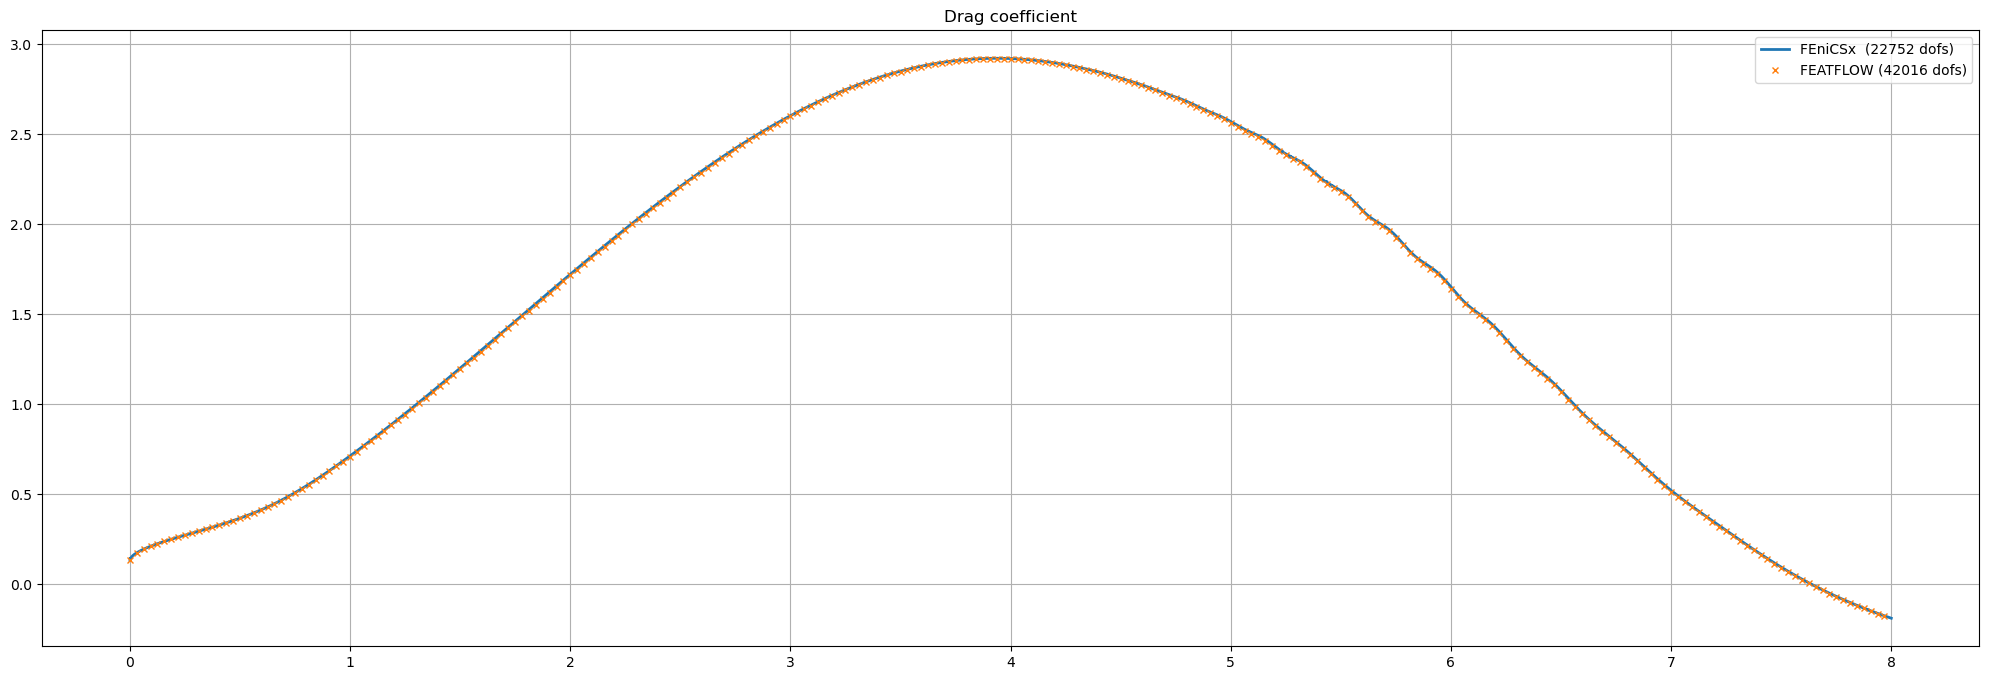

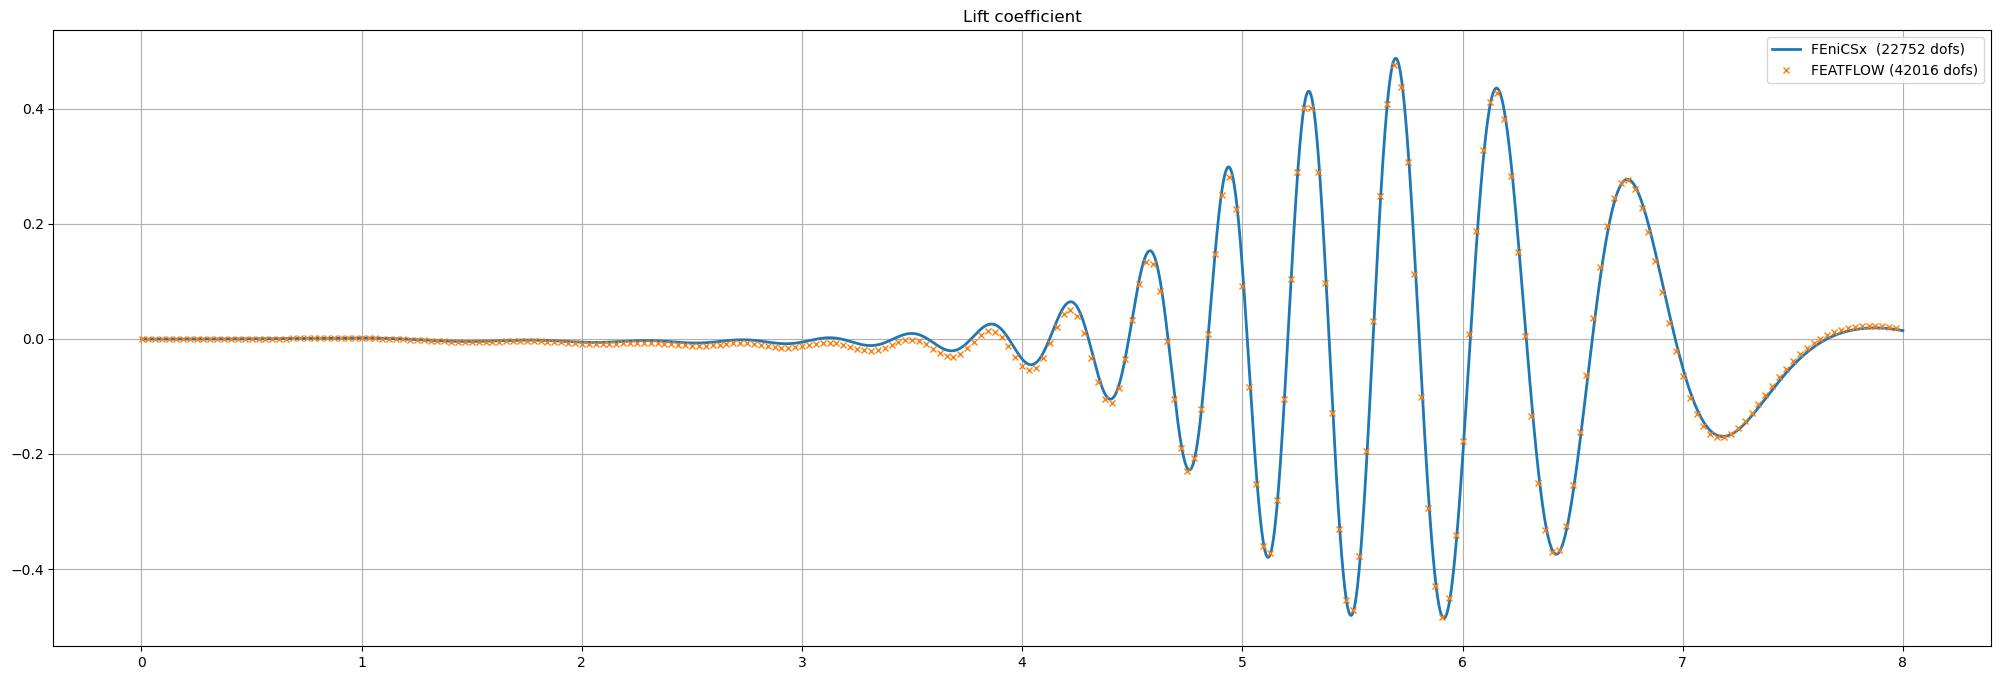

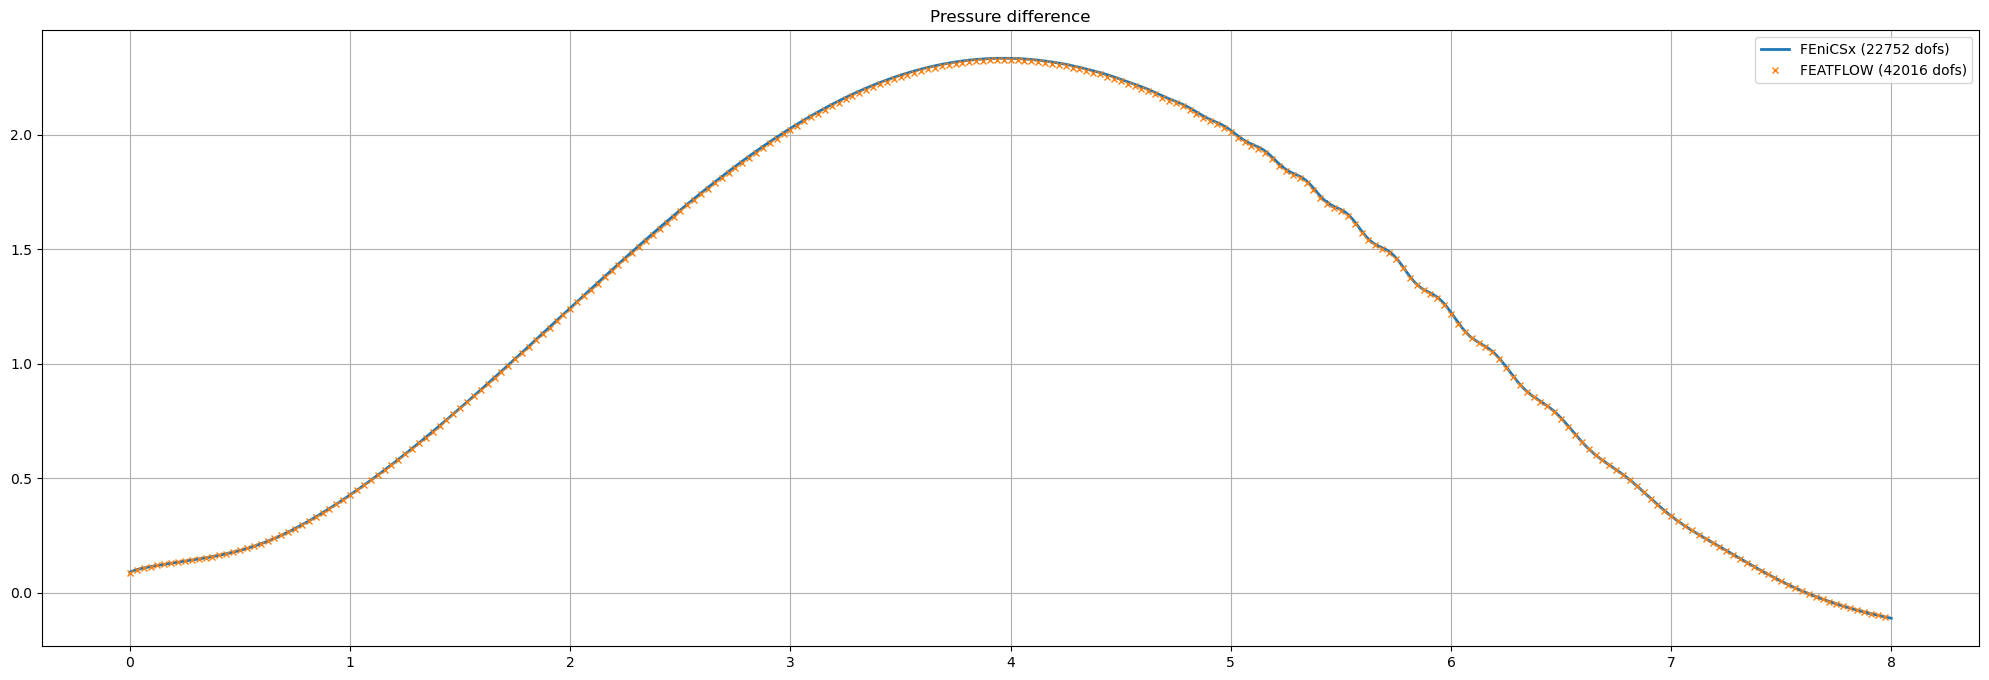

In [19]:
if mesh.comm.rank == 0:
    if not os.path.exists("figures"):
        os.mkdir("figures")
    num_velocity_dofs = V.dofmap.index_map_bs * V.dofmap.index_map.size_global
    num_pressure_dofs = Q.dofmap.index_map_bs * V.dofmap.index_map.size_global

    turek = np.loadtxt("bdforces_lv4")
    turek_p = np.loadtxt("pointvalues_lv4")
    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_u, C_D, label=r"FEniCSx  ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(turek[1:, 1], turek[1:, 3], marker="x", markevery=50,
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Drag coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("figures/drag_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_u, C_L, label=r"FEniCSx  ({0:d} dofs)".format(
        num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(turek[1:, 1], turek[1:, 4], marker="x", markevery=50,
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Lift coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("figures/lift_comparison.png")

    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(t_p, p_diff, label=r"FEniCSx ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(turek[1:, 1], turek_p[1:, 6] - turek_p[1:, -1], marker="x", markevery=50,
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Pressure difference")
    plt.grid()
    plt.legend()
    plt.savefig("figures/pressure_comparison.png")